# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
holding.round(5)

,Price in USDT,Weights in %
Total,1662.91325,1.00000
BTCUSDT,549.43347,0.33040
TRXUSDT,279.93914,0.16834
JASMYUSDT,234.74975,0.14117
SOLUSDT,224.64690,0.13509
OMUSDT,185.84215,0.11176
ETHUSDT,154.94178,0.09317
BBUSDT,33.34045,0.02005
BNBUSDT,0.01961,0.00001
PEPEUSDT,0.00000,0.00000


In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
2024-09-02 00:00:00
LDUMAUSDT not retrieved
LDTRXUSDT not retrieved
LDUMAUSDT
LDTRXUSDT


In [13]:
positions=positions.sort_index()

In [14]:
positions.index=pd.to_datetime(positions.index)

In [15]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [16]:
positions.to_excel('Positions.xlsx')

In [17]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [18]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [19]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [20]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [21]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [22]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [23]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

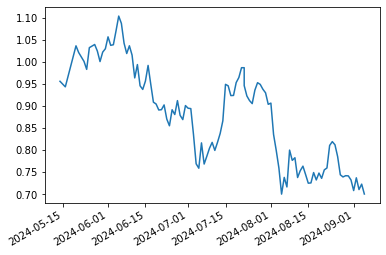

In [24]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [25]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [26]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [27]:
returns_to_use.columns

Index(['1000SATSUSDT', 'AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'CFXUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT',
       'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SANDUSDT',
       'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT',
       'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT',
       'WBTCUSDT', 'WLDUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [28]:
limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [29]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.519914
BTCUSDT,0.400000
PEPEUSDT,0.061284
JASMYUSDT,0.018803


In [30]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [31]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
TRXUSDT,0.870765
OMUSDT,0.129235


## Real Portfolio vs Optimal

In [32]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,549.433468,3.304042e-01,0.000000,0.000000
TRXUSDT,279.939140,1.683426e-01,0.870765,-0.702422
JASMYUSDT,234.749748,1.411678e-01,0.000000,0.000000
SOLUSDT,224.646896,1.350924e-01,0.000000,0.000000
OMUSDT,185.842151,1.117570e-01,0.129235,-0.017478
ETHUSDT,154.941781,9.317490e-02,0.000000,0.000000
BBUSDT,33.340453,2.004942e-02,0.000000,0.000000
BNBUSDT,0.019607,1.179054e-05,0.000000,0.000000
PEPEUSDT,0.000002,9.713074e-10,0.000000,0.000000


In [33]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,549.433468,3.304042e-01,0.400000,-0.069596
TRXUSDT,279.939140,1.683426e-01,0.000000,0.000000
JASMYUSDT,234.749748,1.411678e-01,0.018803,0.122365
SOLUSDT,224.646896,1.350924e-01,0.000000,0.000000
OMUSDT,185.842151,1.117570e-01,0.519914,-0.408157
ETHUSDT,154.941781,9.317490e-02,0.000000,0.000000
BBUSDT,33.340453,2.004942e-02,0.000000,0.000000
BNBUSDT,0.019607,1.179054e-05,0.000000,0.000000
PEPEUSDT,0.000002,9.713074e-10,0.061284,-0.061284


# Risk Reward Analysis

In [34]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [35]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

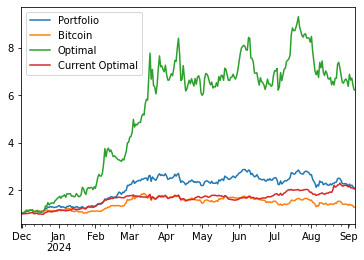

In [36]:
(1+portfolio_perf.iloc[:]).cumprod().plot()

In [37]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

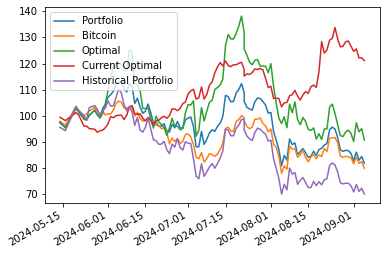

In [38]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [39]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-08-27,87.021745,84.688642,92.422976,126.379571,74.455873
2024-08-28,86.438696,84.145117,92.096072,126.632152,73.972108
2024-08-29,86.784037,84.605822,93.873177,128.288965,74.250621
2024-08-30,86.744613,84.270178,94.520708,128.596481,74.210191
2024-08-31,85.636151,84.056109,93.257194,126.638422,73.287799
2024-09-01,82.823978,81.638368,90.176144,124.625644,70.888670
2024-09-02,86.142417,84.205189,97.366406,125.581667,73.774701
2024-09-03,83.034339,81.830358,93.914762,122.141354,71.119955
2024-09-04,84.470836,82.515248,95.090560,122.167041,72.341855
2024-09-05,81.869129,79.925891,90.749521,121.105209,70.104808


<AxesSubplot:>

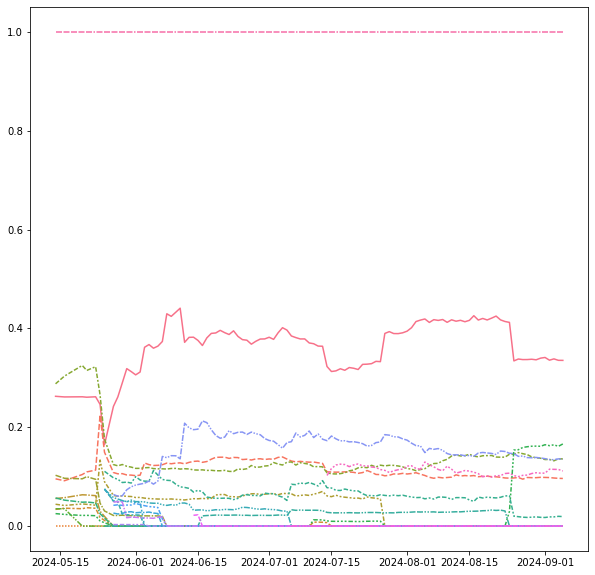

In [40]:
plt.figure(figsize=(10,10))
sns.lineplot(data=weights_ex_post,legend=False,linestyle='solid')

## Volatilities

In [41]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.788795
dtype: float64

In [42]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.486446
dtype: float64

In [43]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.482502
Bitcoin            0.450343
Optimal            0.790163
Current Optimal    0.336974
dtype: float64

In [44]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.25751714617254945

## Risk Contribution

In [45]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.014243,0.057863,0.137994,0.051972,0.086021
JASMYUSDT,0.002258,0.004129,0.009107,0.000704,0.008403
OMUSDT,0.972090,0.920958,0.808903,0.720567,0.088336
PEPEUSDT,0.011409,0.017049,0.043997,0.010492,0.033505


In [46]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.455677,0.311498,0.265816,0.084877,0.180940
TRXUSDT,-0.199738,0.224433,0.044697,0.012719,0.031978
JASMYUSDT,0.232541,0.126376,0.250224,0.088479,0.161745
SOLUSDT,0.260837,0.122210,0.175284,0.040429,0.134855
OMUSDT,-0.053601,0.134085,0.135390,0.039492,0.095898
ETHUSDT,0.208246,0.072592,0.087455,0.011188,0.076268
BBUSDT,0.096038,0.008806,0.041133,0.003821,0.037312


# Value At Risk

## Historical

In [47]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.06450047602654849, -0.09089901225068411)

In [48]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05037636288727178, -0.06449086861384838)

In [49]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [50]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.012198
TRXUSDT     -0.001854
JASMYUSDT   -0.011217
SOLUSDT     -0.011791
OMUSDT      -0.009065
ETHUSDT     -0.001901
BBUSDT      -0.002028
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050054
Name: 2024-08-11 00:00:00, dtype: float64

In [51]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.016765
TRXUSDT     -0.004198
JASMYUSDT   -0.014124
SOLUSDT     -0.011006
OMUSDT      -0.008456
ETHUSDT     -0.005783
BBUSDT      -0.002097
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.062428
dtype: float64

## Parametric

In [52]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.0818735838057067, -0.10493929764669316)

In [53]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05040363941380424, -0.06460352989401112)

## Multivariate

In [54]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07627642866659512, -0.0964844761531347)

In [55]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.050188046062053196, -0.06304642576469467)

In [56]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.013876
TRXUSDT     -0.002364
JASMYUSDT   -0.010977
SOLUSDT     -0.009262
OMUSDT      -0.007049
ETHUSDT     -0.005005
BBUSDT      -0.002324
Portfolio   -0.050857
dtype: float64

## Copulas

### Gaussian Copula

In [57]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07315334116215785, -0.09348429497178536)

In [58]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05069269675828267, -0.06360131352370986)

In [59]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.013833
TRXUSDT     -0.001974
JASMYUSDT   -0.012895
SOLUSDT     -0.009025
OMUSDT      -0.006564
ETHUSDT     -0.004707
BBUSDT      -0.001906
Portfolio   -0.050906
dtype: float64

### Student Copula

In [60]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07408589029226491, -0.09572635132757534)

In [61]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.052241832352120175, -0.06621778621480885)

In [62]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.014197
TRXUSDT     -0.002728
JASMYUSDT   -0.011130
SOLUSDT     -0.009206
OMUSDT      -0.007269
ETHUSDT     -0.004963
BBUSDT      -0.002284
Portfolio   -0.051776
dtype: float64

### Gumbel Copula

In [63]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.15413251176250703, -0.2170937294655596)

In [64]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05779583896205373, -0.07606224034219769)

In [65]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.018401
TRXUSDT     -0.002325
JASMYUSDT   -0.015748
SOLUSDT     -0.007638
OMUSDT      -0.009729
ETHUSDT     -0.002260
BBUSDT      -0.000538
Portfolio   -0.056638
dtype: float64

### Monte Carlo

In [66]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [67]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08219261008734463, -0.10212792617766474)

In [68]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0502426962353826, -0.06229565929376149)

In [69]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.013185
TRXUSDT     -0.001900
JASMYUSDT   -0.013408
SOLUSDT     -0.009259
OMUSDT      -0.007208
ETHUSDT     -0.004364
BBUSDT      -0.002045
Portfolio   -0.051368
dtype: float64

## VaR Violation

In [70]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.062801,-0.115085,-0.100970,-0.025108
2024-01-15,-0.062801,-0.115081,-0.098668,0.014660
2024-01-16,-0.062801,-0.115984,-0.094616,0.065066
2024-01-17,-0.062801,-0.118421,-0.102824,-0.037425
2024-01-18,-0.062801,-0.120550,-0.106767,-0.036136
...,...,...,...,...
2024-09-03,-0.058957,-0.094820,-0.092424,-0.035450
2024-09-04,-0.058957,-0.094590,-0.092671,0.012520
2024-09-05,-0.059051,-0.095785,-0.097231,-0.045652
2024-09-06,-0.059051,-0.095018,-0.096117,-0.030344


In [71]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.026945,-0.076595,-0.071497,-0.017249
2024-05-29,-0.023626,-0.074138,-0.064169,-0.008351
2024-05-30,-0.023626,-0.063820,-0.058992,0.032815
2024-05-31,-0.023626,-0.062397,-0.055458,0.015030
2024-06-01,-0.023626,-0.062347,-0.055856,0.026217
...,...,...,...,...
2024-09-03,-0.049485,-0.067689,-0.069646,-0.036081
2024-09-04,-0.049485,-0.068613,-0.070496,0.017300
2024-09-05,-0.049485,-0.069813,-0.075392,-0.030800
2024-09-06,-0.049485,-0.070522,-0.078238,-0.026288


<AxesSubplot:>

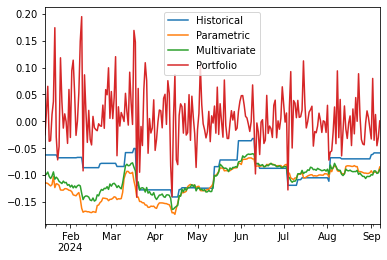

In [72]:
var_data.plot()

<AxesSubplot:>

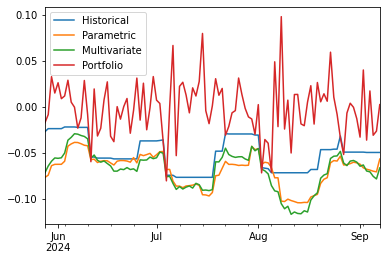

In [73]:
current_var_data.plot()

In [74]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.021008,0.008403,0.012605
Kupiec Stat,5.337456,13.093724,9.878267
P-value,0.020872,0.000296,0.001672


In [75]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.07767,0.038835,0.029126
Kupiec Stat,1.430945,0.291844,1.104592
P-value,0.23161,0.589041,0.293261


## Principal Component Analysis

### Historical PCA

In [76]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78892085, 0.06473654, 0.05332455, 0.04853356, 0.0444845 ])

In [77]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

1000SATSUSDT    0.023701
AAVEUSDT        0.013919
ADAUSDT         0.014035
ALGOUSDT        0.015500
APTUSDT         0.014627
                  ...   
WLDUSDT         0.021100
XECUSDT         0.015025
XLMUSDT         0.009436
XRPUSDT         0.009095
XTZUSDT         0.014137
Name: PC1, Length: 66, dtype: float64

<AxesSubplot:>

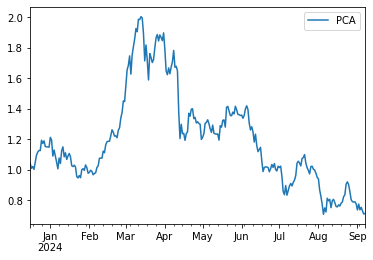

In [78]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

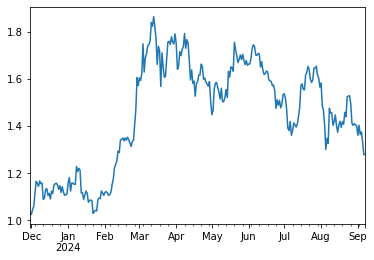

In [79]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [80]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA             0.000000
SANDUSDT        0.298171
ADAUSDT         0.324389
XTZUSDT         0.329718
ALGOUSDT        0.344460
                  ...   
1000SATSUSDT    0.972743
PEPEUSDT        0.991961
FLOKIUSDT       1.000447
WLDUSDT         1.016706
OMUSDT          1.303573
Length: 67, dtype: float64

<AxesSubplot:>

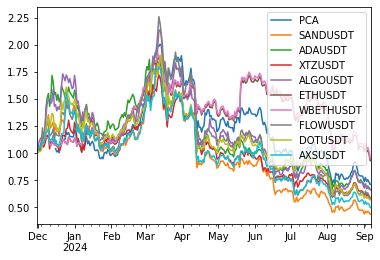

In [81]:
(1+comparison[distances.index[:10]]).cumprod().plot()

### Current PCA

In [82]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.67031925, 0.14044733, 0.08378862, 0.07284767, 0.03259713])

In [83]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.063054
TRXUSDT      0.015584
JASMYUSDT    0.155900
SOLUSDT      0.102923
OMUSDT       0.100076
ETHUSDT      0.085613
BBUSDT       0.247663
BNBUSDT      0.068023
PEPEUSDT     0.161164
Name: PC1, dtype: float64

<AxesSubplot:>

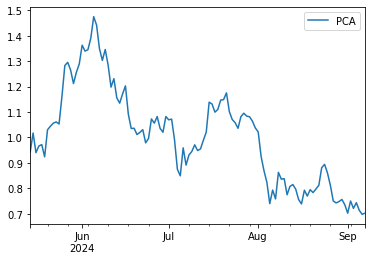

In [84]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

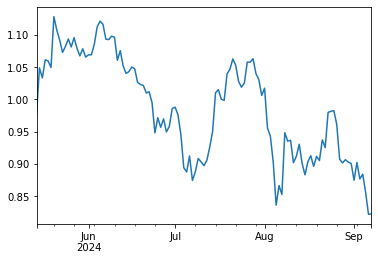

In [85]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [86]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.325656
SOLUSDT      0.335961
BNBUSDT      0.352544
BTCUSDT      0.358211
JASMYUSDT    0.417153
PEPEUSDT     0.452126
OMUSDT       0.506448
TRXUSDT      0.526630
BBUSDT       0.604739
dtype: float64

<AxesSubplot:>

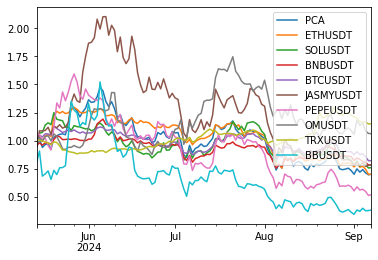

In [87]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [88]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.950783
BBUSDT       1.738501
JASMYUSDT    1.283041
SOLUSDT      1.170476
BTCUSDT      1.000000
OMUSDT       0.997047
ETHUSDT      0.957041
BNBUSDT      0.670474
TRXUSDT      0.287742
Name: BTCUSDT, dtype: float64

In [89]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       1.955216
PEPEUSDT     1.876403
ETHUSDT      1.445824
OMUSDT       1.429975
SOLUSDT      1.324879
BTCUSDT      1.000000
JASMYUSDT    0.864141
BNBUSDT      0.574754
TRXUSDT      0.380679
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [90]:
results={}
window=15

for i in range(0,ex_ante_perf_to_use.shape[0],window):
    
    try:
        
        if i+window>ex_ante_perf_to_use.shape[0]:
            
            dataset=ex_ante_perf_to_use.iloc[i:-1]

        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=ex_ante_perf_to_use.iloc[i:i+window].index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,TRXUSDT,JASMYUSDT,SOLUSDT,OMUSDT,ETHUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-28,0.000000,0.000000,0.600325,0.004690,0.000000,0.0,0.0,0.0,0.394985
2024-06-12,0.000000,0.848841,0.151159,0.000000,0.000000,0.0,0.0,0.0,0.000000
2024-06-27,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2024-07-12,0.000000,0.851742,0.000000,0.000000,0.148258,0.0,0.0,0.0,0.000000
2024-07-27,0.525106,0.000000,0.000000,0.474894,0.000000,0.0,0.0,0.0,0.000000
2024-08-11,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2024-08-26,0.000000,0.470877,0.000000,0.529123,0.000000,0.0,0.0,0.0,0.000000
2024-09-07,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000
